# Homework 4

In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import eig
from scipy.optimize import fsolve
from ipywidgets import interact, FloatSlider

## Question 1

In [63]:
def dynamics_q1(t, x, mu0, mu1):
    y = x
    dydtau = mu0 + mu1*y - y**3
    return dydtau

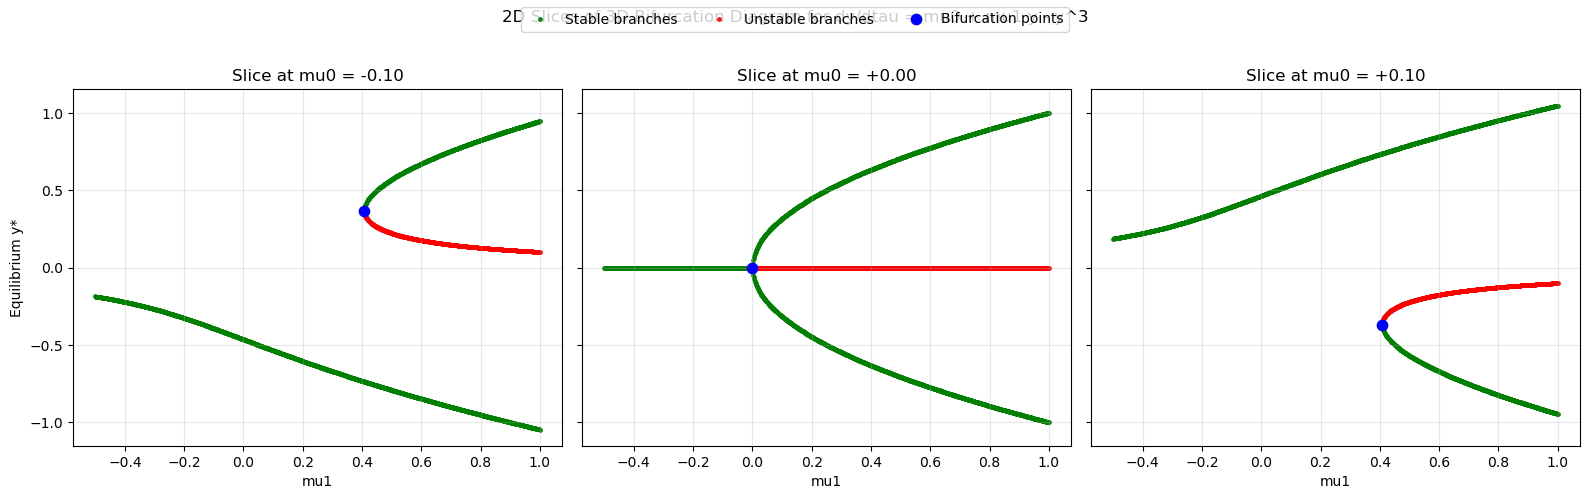

In [64]:
def equilibria_q1(mu0, mu1):
    coeffs = [1.0, 0.0, -mu1, -mu0]
    roots = np.roots(coeffs)
    real_roots = roots[np.isclose(roots.imag, 0.0, atol=1e-9)].real
    return np.sort(real_roots)

def is_stable_q1(y_eq, mu1):
    return (mu1 - 3.0 * y_eq**2) < 0.0

def bifurcation_points_q1(mu0, tol=1e-12):
    if np.abs(mu0) < tol:
        return [(0.0, 0.0)]

    y_fold = np.cbrt(-mu0 / 2.0)
    mu1_fold = 3.0 * y_fold**2
    return [(mu1_fold, y_fold)]

def plot_bifurcation_slices_q1(mu0_values=(-0.1, 0.0, 0.1), mu1_min=-0.5, mu1_max=1.0, n_mu1=900):
    mu1_grid = np.linspace(mu1_min, mu1_max, n_mu1)
    fig, axes = plt.subplots(1, len(mu0_values), figsize=(16, 4.8), sharey=True)

    if len(mu0_values) == 1:
        axes = [axes]

    for ax, mu0 in zip(axes, mu0_values):
        mu1_stable, y_stable = [], []
        mu1_unstable, y_unstable = [], []

        for mu1 in mu1_grid:
            y_eqs = equilibria_q1(mu0, mu1)
            for y_eq in y_eqs:
                if is_stable_q1(y_eq, mu1):
                    mu1_stable.append(mu1)
                    y_stable.append(y_eq)
                else:
                    mu1_unstable.append(mu1)
                    y_unstable.append(y_eq)

        ax.scatter(mu1_stable, y_stable, s=6, color='green', alpha=0.9, label='Stable branches')
        ax.scatter(mu1_unstable, y_unstable, s=6, color='red', alpha=0.9, label='Unstable branches')

        bif_pts = bifurcation_points_q1(mu0)
        bif_mu1 = [pt[0] for pt in bif_pts if mu1_min <= pt[0] <= mu1_max]
        bif_y = [pt[1] for pt in bif_pts if mu1_min <= pt[0] <= mu1_max]
        if len(bif_mu1) > 0:
            ax.scatter(bif_mu1, bif_y, s=55, color='blue', zorder=5, label='Bifurcation points')

        ax.set_title(f'Slice at mu0 = {mu0:+.2f}')
        ax.set_xlabel('mu1')
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel('Equilibrium y*')
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3, frameon=True)
    fig.suptitle('2D Slices of 3D Bifurcation Diagram for dy/dtau = mu0 + mu1 y - y^3', y=1.03)
    plt.tight_layout()
    plt.show()

plot_bifurcation_slices_q1(mu0_values=(-0.1, 0.0, 0.1))

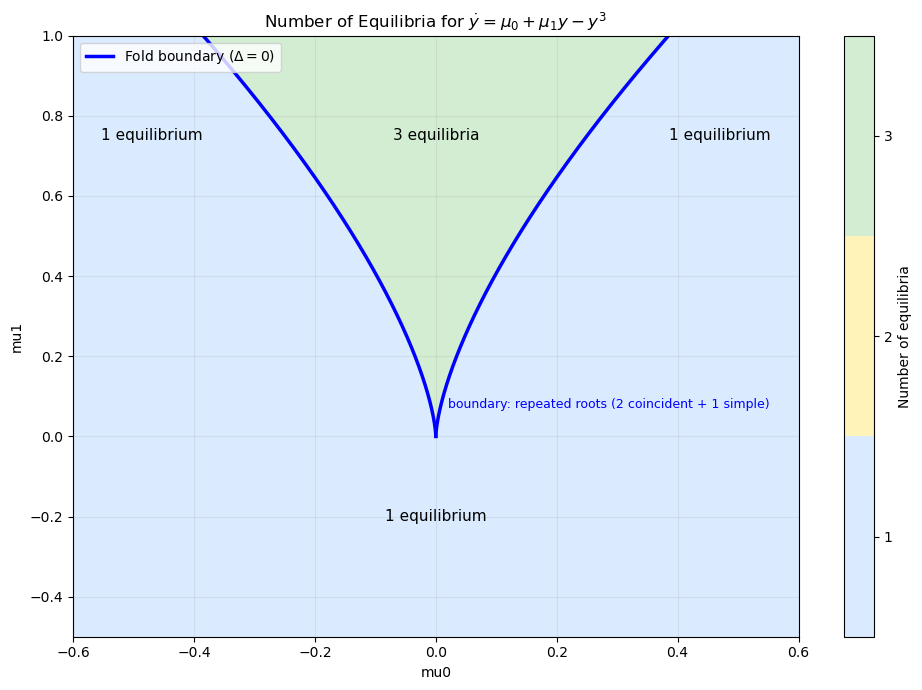

In [78]:
def plot_equilibria_regions_param_space_q1(
    mu0_min=-0.6, mu0_max=0.6, mu1_min=-0.5, mu1_max=1.0, n_mu0=500, n_mu1=500, tol=1e-9
):
    mu0_vals = np.linspace(mu0_min, mu0_max, n_mu0)
    mu1_vals = np.linspace(mu1_min, mu1_max, n_mu1)
    MU0, MU1 = np.meshgrid(mu0_vals, mu1_vals, indexing='xy')

    disc = 4.0 * MU1**3 - 27.0 * MU0**2

    region = np.full_like(disc, np.nan, dtype=float)
    region[disc < -tol] = 1.0
    region[disc > tol] = 3.0
    region[np.abs(disc) <= tol] = 2.0

    fig, ax = plt.subplots(figsize=(10, 7))
    levels = [0.5, 1.5, 2.5, 3.5]
    colors = ['#d6e9ff', '#fff2b2', '#cdeccd']
    cf = ax.contourf(MU0, MU1, region, levels=levels, colors=colors, alpha=0.9)

    mu1_pos = np.linspace(max(0.0, mu1_min), mu1_max, 500)
    mu0_branch = (2.0 / (3.0 * np.sqrt(3.0))) * mu1_pos**1.5
    ax.plot(mu0_branch, mu1_pos, color='blue', linewidth=2.5)
    ax.plot(-mu0_branch, mu1_pos, color='blue', linewidth=2.5, label='Fold boundary ($\\Delta=0$)')

    ax.set_xlabel('mu0')
    ax.set_ylabel('mu1')
    ax.set_title('Number of Equilibria for $\\dot y = \\mu_0 + \\mu_1 y - y^3$')
    ax.grid(True, alpha=0.25)

    cbar = fig.colorbar(cf, ax=ax, ticks=[1, 2, 3])
    cbar.set_label('Number of equilibria')

    ax.text(0.0, 0.75, '3 equilibria', ha='center', va='center', fontsize=11)
    ax.text(0.0, -0.2, '1 equilibrium', ha='center', va='center', fontsize=11)
    ax.text(0.47, 0.75, '1 equilibrium', ha='center', va='center', fontsize=11)
    ax.text(-0.47, 0.75, '1 equilibrium', ha='center', va='center', fontsize=11)
    ax.text(0.02, 0.07, 'boundary: repeated roots (2 coincident + 1 simple)', fontsize=9, color='blue')

    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

plot_equilibria_regions_param_space_q1()

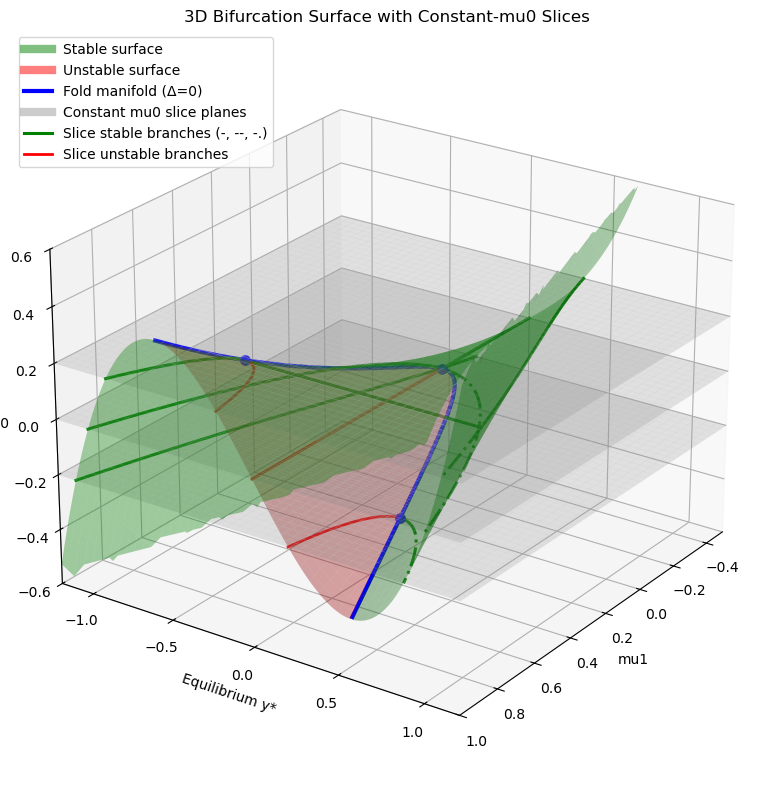

In [83]:
def plot_bifurcation_surface_q1(
    mu1_min=-0.5, mu1_max=1.0, y_min=-1.2, y_max=1.2, n_mu1=180, n_y=220,
    mu0_slices=(-0.2, 0.0, 0.2), mu0_min=-0.6, mu0_max=0.6
):
    mu1_vals = np.linspace(mu1_min, mu1_max, n_mu1)
    y_vals = np.linspace(y_min, y_max, n_y)
    MU1, YEQ = np.meshgrid(mu1_vals, y_vals)

    MU0 = YEQ**3 - MU1 * YEQ
    in_mu0_domain = (MU0 >= mu0_min) & (MU0 <= mu0_max)

    stable_mask = (MU1 - 3.0 * YEQ**2) < 0.0
    unstable_mask = ~stable_mask

    X_stable = np.where(stable_mask & in_mu0_domain, MU1, np.nan)
    Y_stable = np.where(stable_mask & in_mu0_domain, YEQ, np.nan)
    Z_stable = np.where(stable_mask & in_mu0_domain, MU0, np.nan)

    X_unstable = np.where(unstable_mask & in_mu0_domain, MU1, np.nan)
    Y_unstable = np.where(unstable_mask & in_mu0_domain, YEQ, np.nan)
    Z_unstable = np.where(unstable_mask & in_mu0_domain, MU0, np.nan)

    fig = plt.figure(figsize=(11, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(
        X_stable, Y_stable, Z_stable,
        color='green', alpha=0.35, linewidth=0, antialiased=True
    )
    ax.plot_surface(
        X_unstable, Y_unstable, Z_unstable,
        color='red', alpha=0.35, linewidth=0, antialiased=True
    )

    y_bif = np.linspace(y_min, y_max, 800)
    mu1_bif = 3.0 * y_bif**2
    mu0_bif = -2.0 * y_bif**3
    bif_mask = (mu0_bif >= mu0_min) & (mu0_bif <= mu0_max) & (mu1_bif >= mu1_min) & (mu1_bif <= mu1_max)
    ax.plot(
        mu1_bif[bif_mask], y_bif[bif_mask], mu0_bif[bif_mask],
        color='blue', linewidth=3.0, label='Fold manifold (Δ=0)'
    )

    mu1_slice_grid = np.linspace(mu1_min, mu1_max, 500)
    MU1_plane, Y_plane = np.meshgrid(
        np.linspace(mu1_min, mu1_max, 45),
        np.linspace(y_min, y_max, 45)
    )
    stable_styles = ['-', '--', '-.']

    for mu0_slice in mu0_slices:
        if (mu0_slice < mu0_min) or (mu0_slice > mu0_max):
            continue

        MU0_plane = np.full_like(MU1_plane, mu0_slice)
        ax.plot_surface(
            MU1_plane, Y_plane, MU0_plane,
            color='gray', alpha=0.20, linewidth=0.3, edgecolor='lightgray', shade=False
        )

        y_branches = np.full((3, len(mu1_slice_grid)), np.nan)
        stable_branches = np.full((3, len(mu1_slice_grid)), False, dtype=bool)

        for i_mu, mu1 in enumerate(mu1_slice_grid):
            coeffs = [1.0, 0.0, -mu1, -mu0_slice]
            roots = np.roots(coeffs)
            real_roots = np.sort(roots[np.isclose(roots.imag, 0.0, atol=1e-9)].real)

            for branch_idx, y_eq in enumerate(real_roots[:3]):
                y_branches[branch_idx, i_mu] = y_eq
                stable_branches[branch_idx, i_mu] = (mu1 - 3.0 * y_eq**2) < 0.0

        z_slice = np.full_like(mu1_slice_grid, mu0_slice)
        for branch_idx in range(3):
            yb = y_branches[branch_idx]
            st = stable_branches[branch_idx]

            yb_stable = np.where(st, yb, np.nan)
            yb_unstable = np.where(~st, yb, np.nan)

            ax.plot(
                mu1_slice_grid, yb_stable, z_slice,
                color='green', linestyle=stable_styles[branch_idx], linewidth=2.2, alpha=0.95
            )
            ax.plot(mu1_slice_grid, yb_unstable, z_slice, color='red', linewidth=2.0, alpha=0.9)

        if np.isclose(mu0_slice, 0.0, atol=1e-12):
            if mu1_min <= 0.0 <= mu1_max:
                ax.scatter(0.0, 0.0, mu0_slice, color='blue', s=45, zorder=8)
        else:
            y_fold = np.cbrt(-mu0_slice / 2.0)
            mu1_fold = 3.0 * y_fold**2
            if mu1_min <= mu1_fold <= mu1_max:
                ax.scatter(mu1_fold, y_fold, mu0_slice, color='blue', s=45, zorder=8)

    ax.set_xlabel('mu1')
    ax.set_ylabel('Equilibrium y*')
    ax.set_zlabel('mu0')
    ax.set_xlim(mu1_min, mu1_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(mu0_min, mu0_max)
    ax.set_title('3D Bifurcation Surface with Constant-mu0 Slices')
    ax.view_init(elev=24, azim=35)
    ax.grid(True, alpha=0.25)

    from matplotlib.lines import Line2D
    legend_handles = [
        Line2D([0], [0], color='green', lw=6, alpha=0.5, label='Stable surface'),
        Line2D([0], [0], color='red', lw=6, alpha=0.5, label='Unstable surface'),
        Line2D([0], [0], color='blue', lw=3, label='Fold manifold (Δ=0)'),
        Line2D([0], [0], color='gray', lw=6, alpha=0.4, label='Constant mu0 slice planes'),
        Line2D([0], [0], color='green', lw=2.2, linestyle='-', label='Slice stable branches (-, --, -.)'),
        Line2D([0], [0], color='red', lw=2.0, label='Slice unstable branches')
    ]
    ax.legend(handles=legend_handles, loc='upper left')

    plt.tight_layout()
    plt.show()

plot_bifurcation_surface_q1()

\newpage

<div style="page-break-after: always;"></div>

## Question 2

In [2]:
def dynamics_q2(t, y, alpha):
    x1, x2 = y
    dx1dt = alpha * x1**2 - x2**2
    dx2dt = - x2 + x1**2 + x1 * x2
    return [dx1dt, dx2dt]

In [54]:
def center_manifold_q2(x1, alpha):
    return x1**2 + (1 - 2*alpha) * x1**3

def center_manifold_numerical_q2(alpha, x1_max=0.55, n_points=120):
    x_vals = np.linspace(-x1_max, x1_max, n_points)
    h_vals = np.zeros_like(x_vals)

    h_guess = 0.0
    for i, x in enumerate(x_vals):
        def g(h):
            return -h + x**2 + x * h
        try:
            h_sol = fsolve(g, h_guess, xtol=1e-9, maxfev=40)[0]
        except Exception:
            h_sol = h_guess

        if not np.isfinite(h_sol):
            h_sol = h_guess

        h_vals[i] = h_sol
        h_guess = h_sol

    valid = np.isfinite(h_vals) & (np.abs(h_vals) <= 1.0)
    x_vals = x_vals[valid]
    h_vals = h_vals[valid]

    if len(h_vals) >= 5:
        kernel = np.array([1, 2, 3, 2, 1], dtype=float)
        kernel /= kernel.sum()
        h_vals = np.convolve(h_vals, kernel, mode='same')

    return x_vals, h_vals

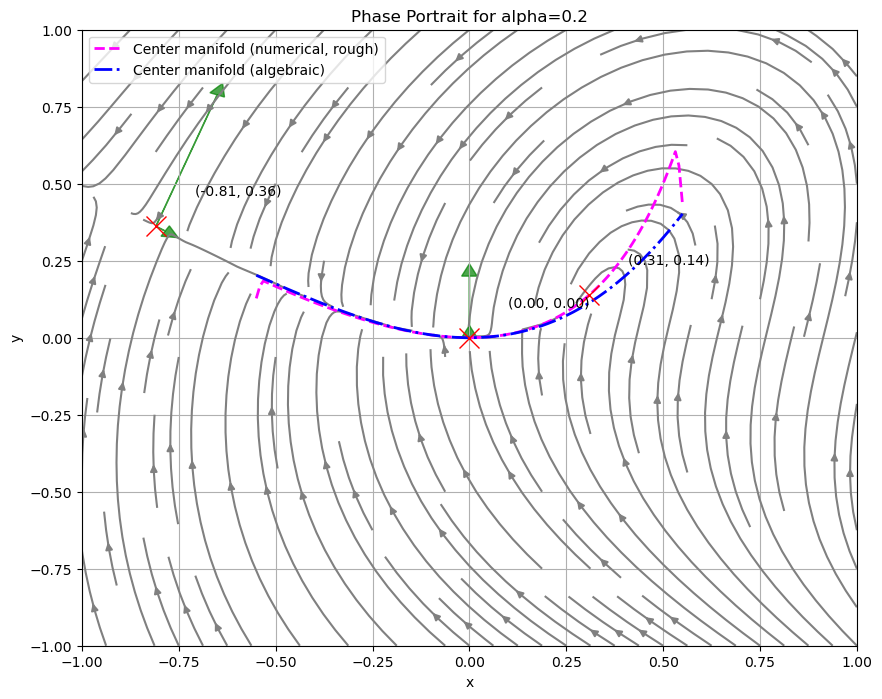

In [58]:
def compute_jacobian(equilibrium, alpha):
    x1_eq, x2_eq = equilibrium
    J = np.array([
        [2*alpha*x1_eq, -2*x2_eq],
        [2*x1_eq + x2_eq, -1 + x1_eq]
    ])
    return J

def plot_phase_portrait_q2(alpha=0.5):
    x1_max = 1
    x2_max = 1
    x1_range = np.linspace(-x1_max, x1_max, 16)
    x2_range = np.linspace(-x2_max, x2_max, 16)
    X1, X2 = np.meshgrid(x1_range, x2_range)
    fig, ax = plt.subplots(figsize=(10, 8))

    dx1 = np.zeros_like(X1)
    dx2 = np.zeros_like(X2)
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            dx1[i, j], dx2[i, j] = dynamics_q2(0, [X1[i, j], X2[i, j]], alpha)

    ax.streamplot(X1, X2, dx1, dx2, density=1.1, color='grey')

    x1_cm_num, x2_cm_num = center_manifold_numerical_q2(alpha=alpha, x1_max=0.55, n_points=120)
    ax.plot(x1_cm_num, x2_cm_num, '--', color='magenta', linewidth=2, label='Center manifold (numerical, rough)')

    x1_cm_alg = np.linspace(-0.55, 0.55, 200)
    x2_cm_alg = center_manifold_q2(x1_cm_alg, alpha)
    ax.plot(x1_cm_alg, x2_cm_alg, '-.', color='blue', linewidth=2, label='Center manifold (algebraic)')

    sqa = np.sqrt(alpha)
    equilibria = [(0, 0),
                  (sqa/(1 + sqa), alpha/(1 + sqa)),
                  (-sqa/(1 - sqa), alpha/(1 - sqa))]
    for eq in equilibria:
        ax.plot(eq[0], eq[1], 'rx', markersize=15)
        ax.text(eq[0] + 0.1, eq[1] + 0.1,
                f'({eq[0]:.2f}, {eq[1]:.2f})',
                color='black')
        
        J = compute_jacobian(eq, alpha)
        evals, evecs = np.linalg.eig(J)
        
        for i, eval in enumerate(evals):
            if np.abs(eval.imag) < 1e-10:
                eval_abs = np.abs(eval)
                evec = np.real(evecs[:, i])
                scale = 0.2 * eval_abs
                ax.arrow(eq[0], eq[1], scale*evec[0], scale*evec[1],
                        head_width=0.04, head_length=0.04, fc='green', ec='green', alpha=0.7)

    ax.legend(loc='upper left')

for alpha in [0.2]:
    plot_phase_portrait_q2(alpha=alpha)
    plt.title(f'Phase Portrait for alpha={alpha}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.show()

\newpage

<div style="page-break-after: always;"></div>

## Question 3

For the map
$$
F(x_1,x_2)=\begin{bmatrix}x_2\\ -\tfrac12 x_1+\tfrac32 x_2-x_2^3\end{bmatrix},
$$
the linearization at the origin is
$$
A=\begin{bmatrix}0&1\\-\tfrac12&\tfrac32\end{bmatrix},
$$
with eigenvalues $\lambda_c=1$ (center) and $\lambda_s=0.5$ (stable).
Using the eigenvector basis
$$
(x,y)^T=P(\tilde x,\tilde y)^T,\quad P=\begin{bmatrix}1&2\\1&1\end{bmatrix},
$$
the center manifold is tangent to the $\tilde x$-axis, so $\tilde y=h(\tilde x)$ with $h(0)=h'(0)=0$.
To third order, the analytical manifold is
$$
\tilde y=2\tilde x^3,
$$
which in original coordinates gives
$$
x=\tilde x+4\tilde x^3,\qquad y=\tilde x+2\tilde x^3.
$$

In [60]:
def map_q3(state):
    x1, x2 = state
    x1_new = x2
    x2_new = -0.5 * x1 + 1.5 * x2 - x2**3
    return np.array([x1_new, x2_new])

P_q3 = np.array([[1.0, 2.0], [1.0, 1.0]])
P_q3_inv = np.linalg.inv(P_q3)

def to_tilde_q3(state):
    return P_q3_inv @ np.asarray(state, dtype=float)

def from_tilde_q3(x_tilde, y_tilde):
    return P_q3 @ np.array([x_tilde, y_tilde], dtype=float)

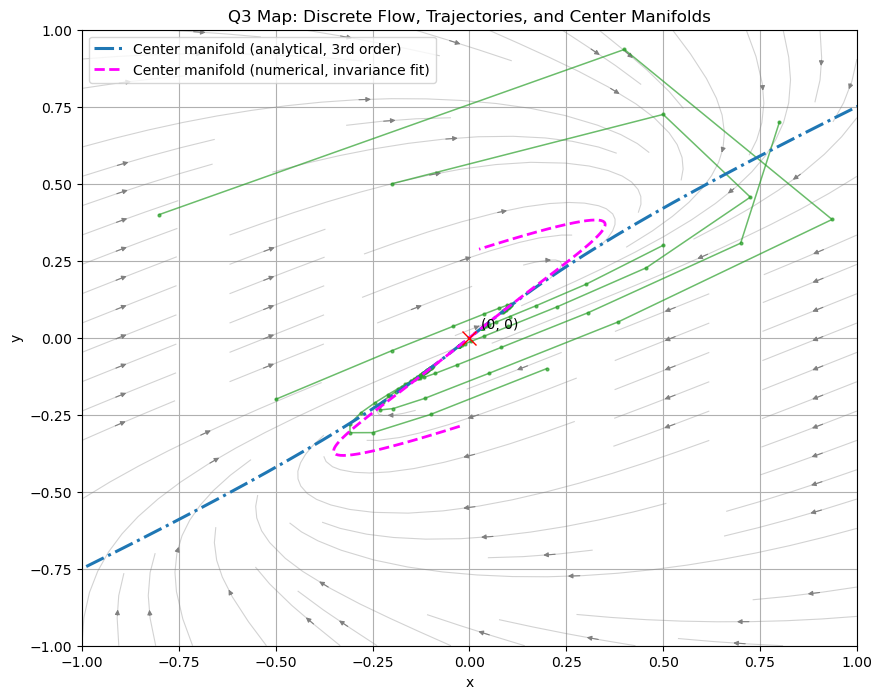

Numerical manifold in aligned coordinates: y_tilde ≈ 0.921410 x_tilde^3 + -8.262797 x_tilde^5


In [61]:
def center_manifold_analytic_q3(x_tilde):
    return 2.0 * x_tilde**3

def center_manifold_numerical_q3(x_tilde_max=0.55, n_points=121):
    from scipy.optimize import least_squares

    x_grid = np.linspace(-x_tilde_max, x_tilde_max, n_points)

    def h_poly(x_tilde, coeffs):
        a3, a5 = coeffs
        return a3 * x_tilde**3 + a5 * x_tilde**5

    def residuals(coeffs):
        res = []
        for x_tilde in x_grid:
            y_tilde = h_poly(x_tilde, coeffs)
            state = from_tilde_q3(x_tilde, y_tilde)
            state_next = map_q3(state)
            x_tilde_next, y_tilde_next = to_tilde_q3(state_next)
            res.append(h_poly(x_tilde_next, coeffs) - y_tilde_next)
        return np.array(res)

    opt = least_squares(residuals, x0=np.array([2.0, 0.0]), xtol=1e-11, ftol=1e-11, gtol=1e-11)
    coeffs = opt.x

    y_tilde_num = h_poly(x_grid, coeffs)
    return x_grid, y_tilde_num, coeffs

def plot_q3_map_with_manifolds():
    x_min, x_max = -1.0, 1.0
    y_min, y_max = -1.0, 1.0

    x_vals = np.linspace(x_min, x_max, 18)
    y_vals = np.linspace(y_min, y_max, 18)
    X, Y = np.meshgrid(x_vals, y_vals)

    X_next = Y
    Y_next = -0.5 * X + 1.5 * Y - Y**3

    U = X_next - X
    V = Y_next - Y

    fig, ax = plt.subplots(figsize=(10, 8))
    sp = ax.streamplot(X, Y, U, V, density=0.75, color='gray', linewidth=0.8, arrowsize=0.7)
    sp.lines.set_alpha(0.35)
    sp.arrows.set_alpha(0.35)

    initial_conditions = [
        (-0.8, 0.4),
        (-0.5, -0.2),
        (-0.2, 0.5),
        (0.2, -0.1),
        (0.5, 0.3),
        (0.8, 0.7),
    ]

    n_steps = 22
    for x0, y0 in initial_conditions:
        traj = np.zeros((n_steps + 1, 2))
        traj[0, :] = [x0, y0]
        for k in range(n_steps):
            traj[k + 1, :] = map_q3(traj[k, :])
            if np.linalg.norm(traj[k + 1, :]) > 3.0:
                traj = traj[:k + 2, :]
                break
        ax.plot(traj[:, 0], traj[:, 1], '-o', color='tab:green', alpha=0.7, markersize=2, linewidth=1.1)

    x_tilde = np.linspace(-0.55, 0.55, 250)

    y_tilde_analytic = center_manifold_analytic_q3(x_tilde)
    xy_analytic = np.array([from_tilde_q3(xi, yi) for xi, yi in zip(x_tilde, y_tilde_analytic)])
    ax.plot(
        xy_analytic[:, 0],
        xy_analytic[:, 1],
        '-.',
        color='tab:blue',
        linewidth=2.2,
        label='Center manifold (analytical, 3rd order)'
    )

    x_tilde_num, y_tilde_num, coeffs_num = center_manifold_numerical_q3(x_tilde_max=0.55, n_points=121)
    xy_num = np.array([from_tilde_q3(xi, yi) for xi, yi in zip(x_tilde_num, y_tilde_num)])
    ax.plot(
        xy_num[:, 0],
        xy_num[:, 1],
        '--',
        color='magenta',
        linewidth=2.0,
        label='Center manifold (numerical, invariance fit)'
    )

    ax.plot(0.0, 0.0, 'rx', markersize=10)
    ax.text(0.03, 0.03, '(0, 0)', color='black')

    ax.set_title('Q3 Map: Discrete Flow, Trajectories, and Center Manifolds')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(True)
    ax.legend(loc='upper left')
    plt.show()

    print(f'Numerical manifold in aligned coordinates: y_tilde ≈ {coeffs_num[0]:.6f} x_tilde^3 + {coeffs_num[1]:.6f} x_tilde^5')

plot_q3_map_with_manifolds()